# Notebook  de Relaciones de entidades

1. Preprocesar la data

In [1]:
import pandas as pd
import re
import spacy
import unidecode
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm

In [2]:
nlp = spacy.load('es_core_news_md')

In [3]:
#Preprocesamiento de las oraciones
def trans(text):
    temp = text.split(' ')
    for k, i in enumerate(temp):
        i = re.sub(r'[“”´!?¡¿]*', '', i)
        i = re.sub(r'[0-9]*', '', i)
        #i=unidecode.unidecode(i)
        #print(i)
        if i.isupper():
            if i == 'DE' or i == 'LA' or i == 'DEL' or i == 'EL':
                i = i.lower()
            firstl = i[0]
            otros = ''
            for j in range(1, len(i)):
                otros = otros + i[j].lower()
            palabra = firstl + otros
            #if palabra.lower() in stop_words:
            #    palabra=''
            temp[k] = palabra
        else:
            #if i.lower() in stop_words:
            #   i=''
            temp[k] = i
    prueba = ' '.join(temp)
    #print(prueba)
    return prueba     

In [ ]:
# WARNING: NO SE UTILIZA
def hallarr(listaent):
    # se separa las personas y locaciones
    persona = []
    ubicacion = []
    listafinal = [] # se almacena la locacion y las personas que pertenecen A LA MISMA ORACIÓN
    for i in listaent:
        if i.label_ == 'PER':
            persona.append(i)
        if i.label_ == 'LOC':
            ubicacion.append(i)
    # se extrae las locaciones y personas que pertenecen a una misma oracion
    for j in ubicacion:
        listemporal = [] #lista temporal 
        listemporal.append(j)
        for i in persona:
            if str(j.doc) == str(i.doc): # WARNING: esta es comparacion de oraciones?
                listemporal.append(i)
        if len(listemporal) > 1:
            listafinal.append(listemporal)
    # Obtener lista unica de personas y locaciones :v
    persona2 = []
    ubicacion2 = []
    for i in persona:
        persona2.append(i.text)
    for j in ubicacion:
        ubicacion2.append(j.text)
    persona2 = list(set(persona2))
    ubicacion2 = list(set(ubicacion2))       
    # Unir las locaciones repetidas
    listafinalv2 = []
    listaperf = []
    for i in ubicacion2:
        #listatr=[]
        listatr = i
        listperl = []
        for j in listafinal:
            if j != []:
                if i == str(j[0]):
                    j.pop(0)
                    listperl.extend(j)
        listafinalv2.append(listatr)
        listaperf.append(listperl)
    # Unir locaciones con nombre similar
    # Se hizo estos for para no hacer muy complejo el codigo
    maxo = []
    for  i in listafinalv2:
        listae = []
        for j, k in enumerate(listafinalv2):
            tr = re.findall(i,k)
            if tr != []:
                dpro = [j]
                if dpro in maxo:
                    ind = maxo.index(dpro)
                    maxo.pop(ind)
                listae.extend(dpro)
        maxo.append(listae)
    pruelife = []
    for i in maxo:
        temps = []
        perso = []
        for j in i:
            temps = listafinalv2[i[0]]
            ste = []
            for l in listaperf[j]:
                ste.append(str(l)) # se usa str porque no es un string
                ste = list(set(ste))
            perso.extend(ste)
            perso = list(set(perso))
        pruelife.append((temps,perso))
    # se retorna la lista con las locaciones y sus personas y las lista unicas
    return pruelife, ubicacion2, persona2

In [ ]:
# WARNING: NO SE UTILIZA
def listadep6(lisg, doc):
    oracion6 = re.sub(r'[,;:.]+', '', str(doc))
    porlo = word_tokenize(oracion6)
    for i in lisg:
        dela = word_tokenize(str(i))
        listapro = []
        #print(dela)
        #print(lisg[0].sent)
        for l in dela:
            for p, k in enumerate(porlo):
                if l == k:
                    listapro.append(p)
        listapro = list(set(listapro))
        listapro2 = []
        for l in listapro:
            count = 0
            for k in listapro:
                if abs(l - k) < len(dela):
                    count = count + 1
            if count == len(dela):
                listapro2.append(l)
        if listapro2 != []:
            lp = listapro2[len(listapro2) - 1]
            texto = ''
            texto = str(i)
            texto = texto.strip()
            porlo[lp] = texto
            for l in range(len(listapro2) - 1):
                listapro2[l] = lp + (l + 1 - len(listapro2))
            listapro2.pop(len(listapro2) - 1)
            #print(porlo)
            ##print(listapro)
            listafin = []
            for l in range(len(porlo)):
                if l in listapro2:
                    pass
                else:
                    listafin.append(porlo[l])
            porlo = listafin
        #print(porlo)
    #print(porlo)
    return porlo

In [4]:
def listadep7(doc):
    listaoword = []
    for token in doc:
        if token.ent_type_ == '':
            a = str(token).split()
            listaoword.extend(a)
        else:
            listaoword.append(str(token))
    return listaoword
#listadep7(per[0].doc)

In [23]:
def proceso(listaprueba, max_word_distance):
    listemp = []
    listatuo = []
    listadepubi = {'nmod', 'nsubj', 'obj'}
    listadepper = {'appos','nsubj', 'obj'}
    for k in listaprueba:
        k = k.replace('.', '')
        doc = nlp(k)
        ubi = []
        per = []
        listauni = []
        b = list(doc.noun_chunks)
        with doc.retokenize() as retokenizer:
            for noun_phrase in b:
                attrs = {
                    "LEMMA": noun_phrase.root.lemma_,
                    "DEP": noun_phrase.root.dep_,
                    "ENT": noun_phrase.root.ent_type_
                }
                retokenizer.merge(noun_phrase, attrs=attrs)
        for token in doc:
            if token.ent_type_ == 'LOC':
                ubi.append(token)
                listemp.append([token, listaprueba[0]])
                listauni.append(token)
            elif token.ent_type_ == 'PER':
                per.append(token)
                listemp.append([token, listaprueba[0]])
                listauni.append(token)
        if len(ubi) > 0 and len(per) > 0:
            porlo = listadep7(per[0].doc)
            for p1 in ubi:
                for p2 in per:
                    if p1.dep_ in listadepubi and p2.dep_ in listadepper:
                        if abs(porlo.index(str(p1)) - porlo.index(str(p2))) < max_word_distance:
                            # print(p1.dep_, p2.dep_, p1, p2)
                            listarelat = [str(p1), str(p2), k, listaprueba[0]]
                            listatuo.append(listarelat)
    return listatuo, listemp

In [25]:
df = pd.read_excel('Prueba de relatos.xlsx')

In [19]:
listatecnica = []
for capitulo in tqdm(range(0,20)):
    o = df['Texto'][capitulo]
    o = re.sub('…', '...', o)
    o = o.replace('...', '.')
    listaprueba = sent_tokenize(o)
    for j, i in enumerate(listaprueba):
        if j == 0:
            i = i.split('\n')
            i = i[0]
        i = i.split('\n')
        i = ' '.join(i)
        i = trans(i)
        listaprueba[j] = i.strip()
    listatuo2, listatemp1 = proceso(listaprueba)
    listatecnica.extend(listatuo2)

100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


In [20]:
#nsubj appos
#obj nsubj 
#nsubj nsubj
#nsubj obj
#appos nsubj
#aposs obj
#nmod obj
df3 = pd.DataFrame(listatecnica)

In [21]:
df3.to_excel('relacionesconectadas3.xlsx')
#df3=pd.read_excel('relacionesconectadas.xlsx')

In [22]:
df = pd.read_excel('Relatos_viajes-Benvenutto.xlsx')

In [15]:
listemp = []
for capitulo in tqdm(range(0, 20)):
    o = df['Texto'][capitulo]
    o = re.sub('…', '...', o)
    o = o.replace('...', '.')
    listaprueba = sent_tokenize(o)
    for j, i in enumerate(listaprueba):
        if j == 0:
            i = i.split('\n')
            i = i[0]
        i = i.split('\n')
        i = ' '.join(i)
        i = trans(i)
        listaprueba[j] = i.strip()
    for k in listaprueba:
        k = k.replace('.','')
        k = k.replace(':','')
        doc = nlp(k)
        b = list(doc.noun_chunks)
        with doc.retokenize() as retokenizer:
            for noun_phrase in b:
                attrs = {
                    "LEMMA": noun_phrase.root.lemma_,
                    "DEP": noun_phrase.root.dep_,
                    "ENT": noun_phrase.root.ent_type_
                }
                retokenizer.merge(noun_phrase, attrs=attrs)
        for token in doc:
            if token.ent_type_ != '':
                #print(token)
                listemp.append([token, listaprueba[0]])

100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


In [16]:
locaciones = []
personas = []
for i in listemp:
    if i[0].ent_type_ == 'LOC':
        locaciones.append(i)
    if i[0].ent_type_ == 'PER':
        personas.append(i)

In [26]:
len(personas), len(locaciones)

(1369, 1455)

In [ ]:
#personas "appos,nmod,nsubj,obj,flat"
#ubicaciones nmod

In [27]:
df5=pd.DataFrame(personas)
df5.to_excel('personas.xlsx')

In [29]:
df3

,0,1,2,3
0,Segura,Montero,Gritan los mocitos Por todo el Cercau Traigan ...,la Placita de la Recoleta
1,Segura,Caucau Muestras,Gritan los mocitos Por todo el Cercau Traigan ...,la Placita de la Recoleta
2,Lima,José Santos,"Más al centro de la plazuela hay una pila, clá...",la Placita de la Recoleta
3,Lima,Vénzalo,Es el Hospicio un refugio de viejas tradicione...,la Placita de la Recoleta
4,San Francisco de Paula,Vénzalo,Es el Hospicio un refugio de viejas tradicione...,la Placita de la Recoleta
...,...,...,...,...
146,la Bella Jardinera,Carlitos Bar,"No nos conviene ahora caminar toda la calle, l...",La Plaza de Armas
147,Prado,Maitines,Aun antes que las vocingleras campanitas conve...,La Plaza de Armas
148,Enero,Maitines,Aun antes que las vocingleras campanitas conve...,La Plaza de Armas
149,Ayacucho,Pedro Castre,"Pedro Castre, cuando estuvo de administrador d...",La Plaza de Armas


In [52]:
df3[df3[0]=='la Micheo']

,0,1,2,3
89,la Micheo,Don Manuel,Don Manuel es el historiador popular de la pla...,La Plazuela de San Juan de Dios


In [40]:
listalocs=df3[0].tolist()

In [41]:
listalocs=list(set(listalocs))

In [44]:
listaer=[]
for i in listalocs:
    a=df3[df3[0]==i]
    perso=a[1].tolist()
    listad=[i, perso, len(perso)]
    listaer.append(listad)

In [45]:
dfg=pd.DataFrame(listaer, columns=['Loc', 'Personas', 'Cant'])

In [46]:
dfg.sort_values('Cant', ascending=False)

,Loc,Personas,Cant
7,Lima,"[José Santos, Vénzalo, Señor, Domo, Timoteo, e...",12
17,San Juan de Dios,"[Boza, Juan de Arona, Dominguito Vallerriestra...",5
22,la Amargura,"[Rafael Ramírez, Braulia, Santitos Posada, Chá...",4
60,Belén,"[Bernardo Monteagudo, María Inmaculada, Belén]",3
41,Guadalupe,"[Biedma, Juan Nepomuceno Vargas, Jesús Bravo]",3
...,...,...,...
38,Zamba,[Albizuri],1
37,Casapalca a Lima,[Subprefecto],1
36,Lemos,[Ilustrísimo Villagómez],1
35,Azpeytia,[Moliére],1


In [53]:
print(dfg['Cant'].sum())

151


In [86]:
word_dists = list(range(2, 50))
n_relations = []

for word_dist in word_dists:
    listatecnica = []
    for capitulo in tqdm(range(0,20)):
        o = df['Texto'][capitulo]
        o = re.sub('…', '...', o)
        o = o.replace('...', '.')
        listaprueba = sent_tokenize(o)
        for j, i in enumerate(listaprueba):
            if j == 0:
                i = i.split('\n')
                i = i[0]
            i = i.split('\n')
            i = ' '.join(i)
            i = trans(i)
            listaprueba[j] = i.strip()
        listatuo2, listatemp1 = proceso(listaprueba, word_dist)
        listatecnica.extend(listatuo2)

    df3 = pd.DataFrame(listatecnica)
    listalocs = df3[0].tolist()
    listalocs = list(set(listalocs))

    listemp = []
    for capitulo in tqdm(range(0, 20)):
        o = df['Texto'][capitulo]
        o = re.sub('…', '...', o)
        o = o.replace('...', '.')
        listaprueba = sent_tokenize(o)
        for j, i in enumerate(listaprueba):
            if j == 0:
                i = i.split('\n')
                i = i[0]
            i = i.split('\n')
            i = ' '.join(i)
            i = trans(i)
            listaprueba[j] = i.strip()
        for k in listaprueba:
            k = k.replace('.','')
            k = k.replace(':','')
            doc = nlp(k)
            b = list(doc.noun_chunks)
            with doc.retokenize() as retokenizer:
                for noun_phrase in b:
                    attrs = {
                        "LEMMA": noun_phrase.root.lemma_,
                        "DEP": noun_phrase.root.dep_,
                        "ENT": noun_phrase.root.ent_type_
                    }
                    retokenizer.merge(noun_phrase, attrs=attrs)
            for token in doc:
                if token.ent_type_ != '':
                    #print(token)
                    listemp.append([token, listaprueba[0]])

    listaer=[]
    for i in listalocs:
        a = df3[df3[0] == i]
        perso = a[1].tolist()
        listad = [i, perso, len(perso)]
        listaer.append(listad)

    dfg=pd.DataFrame(listaer, columns=['Loc', 'Personas', 'Cant'])
    n_relations.append(dfg['Cant'].sum())

100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


In [87]:
import matplotlib.pyplot as plt

In [137]:
min(len(personas), len(locaciones))

1369

In [135]:
len(personas) / len(locaciones)

0.940893470790378

In [138]:
[(n / min(len(personas), len(locaciones)))* len(personas) / len(locaciones) for n in n_relations]

[0.0006872852233676976,
 0.003436426116838488,
 0.004810996563573883,
 0.01168384879725086,
 0.019243986254295534,
 0.027491408934707903,
 0.03505154639175258,
 0.04329896907216495,
 0.052920962199312714,
 0.06391752577319587,
 0.06804123711340206,
 0.07216494845360824,
 0.07491408934707904,
 0.08041237113402062,
 0.0838487972508591,
 0.09072164948453608,
 0.09484536082474226,
 0.09690721649484536,
 0.10103092783505155,
 0.10378006872852234,
 0.10927835051546392,
 0.1134020618556701,
 0.1154639175257732,
 0.12096219931271476,
 0.12508591065292096,
 0.13127147766323025,
 0.1360824742268041,
 0.140893470790378,
 0.1429553264604811,
 0.1450171821305842,
 0.1457044673539519,
 0.14845360824742268,
 0.14982817869415807,
 0.15189003436426116,
 0.15463917525773194,
 0.15670103092783505,
 0.15807560137457044,
 0.16013745704467353,
 0.1628865979381443,
 0.16357388316151203,
 0.16426116838487972,
 0.16563573883161511,
 0.1670103092783505,
 0.1697594501718213,
 0.17044673539518904,
 0.172508591065

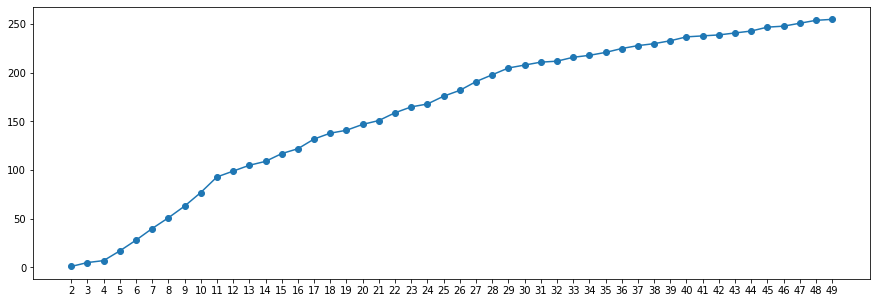

In [92]:
fig = plt.figure(figsize=(15,5))
plt.plot(word_dists, n_relations, marker='o')
plt.xticks(word_dists)
plt.show()

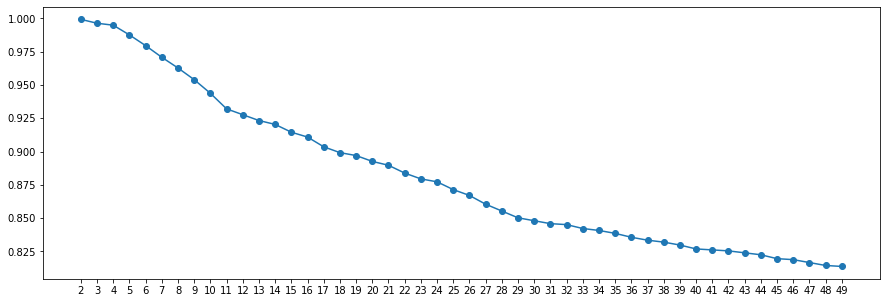

In [162]:
fig = plt.figure(figsize=(15,5))
plt.plot(word_dists, [1 - (n / len(personas)) for n in n_relations], marker='o')
plt.xticks(word_dists)
plt.show()


### Make map

In [32]:
df4 = pd.read_excel('../Visualization/Plazuelas.xlsx')

In [33]:
lista = []
for i in range(len(df4)):
    lista.append('Chávez')

In [34]:
df4['Personajes'] = lista

In [35]:
#df4['Personajes'][15]='Felipe Barreda'
df4['Personajes'][13] = 'Chávez, Manuel Gálvez'

<ipython-input-35-d9d881779c2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Personajes'][13]='Chávez, Manuel Gálvez'


In [39]:
import plotly.express as px

listazero = [10] * len(df4)
fig = px.scatter_mapbox(df4, lat="lat", lon="lon", hover_name="Plazuelas", hover_data=['Lugar actual', 'Personajes'],
                        color_discrete_sequence=["red"], zoom=12, height=700, size=listazero)

fig.update_layout(mapbox_style="open-street-map")
fig.write_html('map.html')

In [97]:
complete_text = ' '.join(df['Texto'].tolist())

In [99]:
sentences = sent_tokenize(complete_text, language='spanish')

In [100]:
len(sentences)

2035

In [102]:
sentences[0]

'LA PLACITA de la RECOLETA\nA Francisco Mendoza y Canaval\nSALIENDO DE LA CALLE DE BELÉN, la mejor y más aristocrática de las calles de la capital, residencia de las familias de buen tono: Soyer y Cabero, Álvarez Calderón, CanavalSoria, Alayza, Irribarren, etc., etc., entre las cuales se ha venido a colar, no se sabe cómo, una fabrica de cigarrillos, la del gordo judío alemán Cohen, propietario de las afamadas marcas “Garibaldi”, “Almirante Grau” y “Huáscar”, y “como quien se va” a la exposición, se llega a un trozo de peña colocado en la esquina a manera de guardacantón y sobre el que todos los chicos del barrio cada vez que pasan junto a él, tienen la ineludible obligación de dar un airoso “salto peruano con patada” o sin ella.'

In [103]:
sentences_tokens = [word_tokenize(sent, language='spanish') for sent in sentences]

In [105]:
sentences_lens = [len(sent_tokens) for sent_tokens in sentences_tokens]

In [119]:
import numpy as np

In [120]:
np.mean(sentences_lens)

42.35479115479116

In [121]:
np.std(sentences_lens)

33.221554241697135

In [131]:
list(range(25,100,25))

[25, 50, 75]

In [133]:
np.percentile(sentences_lens, q=range(25,101,25))

array([ 20.,  34.,  55., 246.])

(array([0.04176904, 0.11302211, 0.19115479, 0.27665848, 0.37297297,
        0.46388206, 0.54054054, 0.6034398 , 0.64717445, 0.70515971,
        0.75577396, 0.79410319, 0.82506143, 0.85307125, 0.87960688,
        0.8958231 , 0.90663391, 0.91498771, 0.92628993, 0.93660934,
        0.94447174, 0.95135135, 0.95724816, 0.96609337, 0.96904177,
        0.97199017, 0.97542998, 0.97690418, 0.97936118, 0.98230958,
        0.98574939, 0.98820639, 0.98968059, 0.99115479, 0.99213759,
        0.99213759, 0.99312039, 0.99410319, 0.995086  , 0.9955774 ,
        0.9960688 , 0.9960688 , 0.9970516 , 0.9980344 , 0.9985258 ,
        0.9985258 , 0.9985258 , 0.9990172 , 0.9995086 , 1.        ]),
 array([  2.  ,   6.88,  11.76,  16.64,  21.52,  26.4 ,  31.28,  36.16,
         41.04,  45.92,  50.8 ,  55.68,  60.56,  65.44,  70.32,  75.2 ,
         80.08,  84.96,  89.84,  94.72,  99.6 , 104.48, 109.36, 114.24,
        119.12, 124.  , 128.88, 133.76, 138.64, 143.52, 148.4 , 153.28,
        158.16, 163.04, 167.92

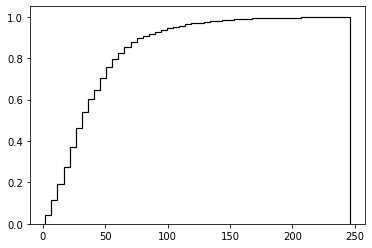

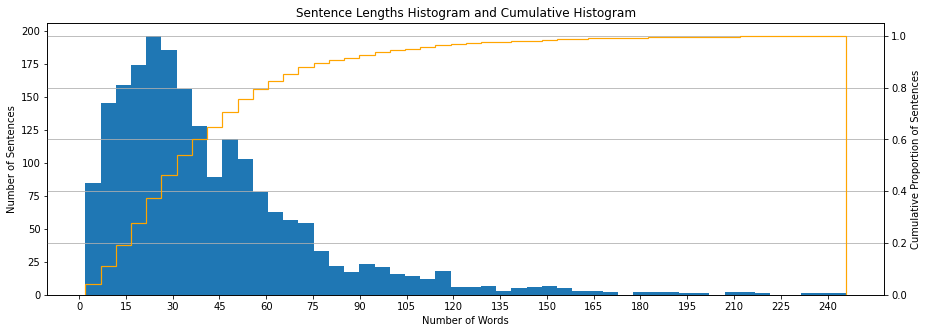

In [249]:
fig1, ax1 = plt.subplots(figsize=(15, 5))

n, array, patches = ax1.hist(sentences_lens, bins=50, label='Histogram')
ax1.set_ylabel('Number of Sentences')
ax1.set_xlabel('Number of Words')
ax1.set_xticks(range(0, 250, 15))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.hist(sentences_lens, bins=50, density=True,
         histtype='step', cumulative=True, facecolor='none', edgecolor='orange', 
         linewidth=1.2, label='Cumulative')
ax2.set_ylabel('Cumulative Proportion of Sentences')

plt.title('Sentence Lengths Histogram and Cumulative Histogram')
plt.grid()

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig('histograms.png', dpi=300)

plt.show()